In [107]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GlobalAveragePooling1D
import seaborn as sns

## Load Data
Pada bagian ini, kita memuat dataset dari file CSV yang berisi data ulasan produk beserta label sentimennya. Kemudian, kita memeriksa informasi tentang dataset tersebut menggunakan `df.info()` untuk melihat tipe data, jumlah data, dan nilai yang hilang.


Fungsi `df.describe(include='O')` digunakan untuk mendapatkan ringkasan statistik deskriptif untuk data kategorikal. `df.head()` akan menampilkan beberapa baris pertama dari dataset untuk memahami bentuk dan struktur data.

In [90]:
# Load data
df = pd.read_csv("sentiment.csv", index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5400 entries, Computers and Laptops to Household
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Product Name     5400 non-null   object 
 1   Location         5400 non-null   object 
 2   Price            5400 non-null   int64  
 3   Overall Rating   5400 non-null   float64
 4   Number Sold      5400 non-null   int64  
 5   Total Review     5400 non-null   int64  
 6   Customer Rating  5400 non-null   int64  
 7   Customer Review  5400 non-null   object 
 8   Sentiment        5400 non-null   object 
 9   Emotion          5400 non-null   object 
dtypes: float64(1), int64(4), object(5)
memory usage: 464.1+ KB


# Show description of the data

In [91]:
# Load data
df.describe(include='O')

,Product Name,Location,Customer Review,Sentiment,Emotion
count,5400,5400,5400,5400,5400
unique,1308,61,5305,2,5
top,Minigold Black Series Logam Mulia Koin Emas Mi...,Jakarta Barat,jelek,Negative,Happy
freq,25,1293,4,2821,1770


# Show first 5 rows of the dataset

In [92]:
df.head()

,Product Name,Location,Price,Overall Rating,Number Sold,Total Review,Customer Rating,Customer Review,Sentiment,Emotion
Category,,,,,,,,,,
Computers and Laptops,Wireless Keyboard i8 Mini TouchPad Mouse 2.4G ...,Jakarta Utara,53500,4.9,5449,2369,5,Alhamdulillah berfungsi dengan baik. Packaging...,Positive,Happy
Computers and Laptops,PAKET LISENSI WINDOWS 10 PRO DAN OFFICE 2019 O...,Kota Tangerang Selatan,72000,4.9,2359,1044,5,"barang bagus dan respon cepat, harga bersaing ...",Positive,Happy
Computers and Laptops,SSD Midasforce 128 Gb - Tanpa Caddy,Jakarta Barat,213000,5.0,12300,3573,5,"barang bagus, berfungsi dengan baik, seler ram...",Positive,Happy
Computers and Laptops,ADAPTOR CHARGER MONITOR LCD LED TV LG merek LG...,Jakarta Timur,55000,4.7,2030,672,5,bagus sesuai harapan penjual nya juga ramah. t...,Positive,Happy
Computers and Laptops,ADAPTOR CHARGER MONITOR LCD LED TV LG merek LG...,Jakarta Timur,55000,4.7,2030,672,5,"Barang Bagus, pengemasan Aman, dapat Berfungsi...",Positive,Happy


## Data Preprocessing

##### Pertama, kita memilih dua kolom yang relevan, yaitu 'Customer Review' untuk teks ulasan dan 'Sentiment' untuk label sentimen. Selanjutnya, kita menghapus nilai yang hilang menggunakan `dropna()` agar dataset bersih.

In [93]:
# Selecting necessary columns and dropping NaN values
data = df[['Customer Review', 'Sentiment']].dropna()

##### Kita juga memvisualisasikan distribusi label sentimen menggunakan plot

C:\Users\USer\AppData\Local\Temp\ipykernel_7700\3422173201.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='Sentiment', palette='viridis')


Text(0.5, 1.0, 'Sentiment Distribution')

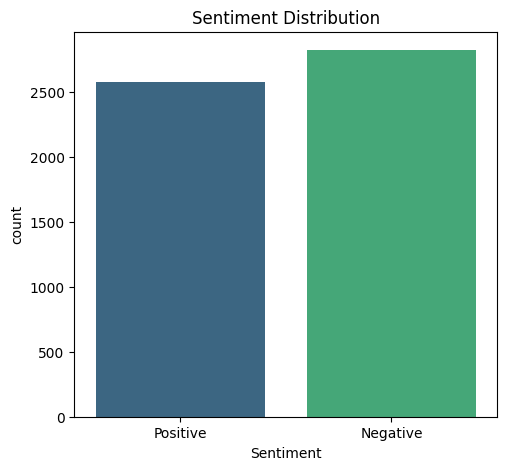

In [94]:
# Visualize distribution of Sentiment
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.countplot(data=data, x='Sentiment', palette='viridis')
plt.title("Sentiment Distribution")

##### Membuat wordcloud untuk menampilkan kata-kata yang sering muncul di ulasan.

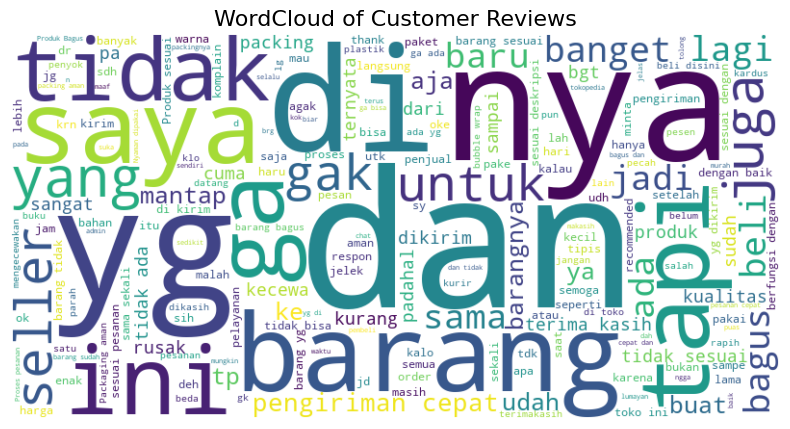

In [95]:
# Generate a wordcloud for customer reviews
text = ' '.join(data['Customer Review'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud of Customer Reviews", fontsize=16)
plt.show()

## Text Preprocessing

Di sini, kita melakukan preprocessing teks untuk mempersiapkan data agar dapat dimasukkan ke dalam model.

In [96]:
# Splitting the data
X = data['Customer Review']
y_sentiment = data['Sentiment']

# Splitting data for Sentiment and Emotion classification
X_train_sentiment, X_test_sentiment, y_train_sentiment, y_test_sentiment = train_test_split(
    X, y_sentiment, test_size=0.2, random_state=42)

Fungsi `preprocess_text()` digunakan untuk mengubah teks menjadi huruf kecil, menghapus tanda baca dan angka, serta menghapus spasi tambahan. Kemudian, fungsi ini diterapkan pada data pelatihan dan pengujian.

In [ ]:
# 2. Text preprocessing
def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = text.strip()  # Remove whitespace
    return text

X_train_sentiment = X_train_sentiment.apply(preprocess_text)
X_test_sentiment = X_test_sentiment.apply(preprocess_text)

## Tokenization and Padding

Pada bagian ini, kita menggunakan `Tokenizer` dari Keras untuk mengubah teks menjadi urutan angka berdasarkan kata yang sering muncul. 

`num_words=5000` berarti hanya 5000 kata yang paling sering digunakan yang akan dipertimbangkan.


Setelah itu, kita mengonversi teks menjadi urutan angka menggunakan `texts_to_sequences()` dan melakukan padding agar panjang setiap urutan teks menjadi sama.

In [ ]:
# 3. Tokenization and padding
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train_sentiment)

# Convert text to sequences
X_train_sentiment_seq = tokenizer.texts_to_sequences(X_train_sentiment)
X_test_sentiment_seq = tokenizer.texts_to_sequences(X_test_sentiment)

# Padding sequences
max_len = 100
X_train_sentiment_pad = pad_sequences(X_train_sentiment_seq, maxlen=max_len, padding='post')
X_test_sentiment_pad = pad_sequences(X_test_sentiment_seq, maxlen=max_len, padding='post')

# Encode labels
label_encoder_sentiment = LabelEncoder()
y_train_sentiment_enc = label_encoder_sentiment.fit_transform(y_train_sentiment)
y_test_sentiment_enc = label_encoder_sentiment.transform(y_test_sentiment)

## RNN Model with Optimizations

Saya mendefinisikan model RNN yang telah dioptimalkan.

Model ini terdiri dari beberapa lapisan RNN berturut-turut, diikuti oleh BatchNormalization untuk stabilitas dan Dropout untuk mencegah overfitting.

Saya juga menggunakan GlobalAveragePooling1D untuk mengurangi dimensi data sekuensial sebelum masuk ke lapisan dense.

Model ini diakhiri dengan dua lapisan dense dengan aktivasi ReLU dan Softmax untuk klasifikasi.

Fungsi `build_optimized_rnn_model()` menerima jumlah kelas output dan mengembalikan model yang sudah dibangun.

In [ ]:
def build_optimized_rnn_model(output_dim):
    model = Sequential()

    # Embedding Layer - Mengonversi kata menjadi representasi vektor
    model.add(Embedding(input_dim=10000, output_dim=512, input_length=max_len))

    # First RNN Layer - Menambahkan lapisan RNN pertama dengan normalisasi batch dan dropout
    model.add(SimpleRNN(256, return_sequences=True))
    model.add(BatchNormalization())  # Normalisasi batch
    model.add(Dropout(0.3))

    # Second RNN Layer - Lapisan RNN kedua dengan normalisasi batch dan dropout
    model.add(SimpleRNN(128, return_sequences=True))
    model.add(BatchNormalization())  # Normalisasi batch
    model.add(Dropout(0.3))

    # Third RNN Layer - Lapisan RNN ketiga, menghasilkan tensor 2D
    model.add(SimpleRNN(64, return_sequences=True))  # Menghasilkan urutan (3 dimensi)
    model.add(BatchNormalization())  # Normalisasi batch
    model.add(Dropout(0.3))

    # Global Pooling Layer - Mengurangi dimensi data sekuensial
    model.add(GlobalAveragePooling1D())  # Agar bisa menangkap informasi lebih baik

    # Fully connected Dense Layers
    model.add(Dense(512, activation='relu', kernel_regularizer='l2'))
    model.add(Dropout(0.3))  # Dropout untuk menghindari overfitting
    model.add(Dense(output_dim, activation='softmax'))  # Softmax untuk klasifikasi

    # Compile Model dengan Learning Rate lebih kecil
    model.compile(optimizer=Adam(learning_rate=0.0001), 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])

    model.build(input_shape=(None, max_len))  # Bentuk input (batch_size, sequence_length)
    return model

e:\Software\Python\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Sentiment Optimized Model Summary:


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_16 (Embedding)        │ (None, 100, 512)       │     5,120,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_36 (SimpleRNN)       │ (None, 100, 256)       │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 100, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 100, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_37 (SimpleRNN)       │ (None, 100, 128)       │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 100, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_38 (SimpleRNN)       │ (None, 100, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 100, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_4      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 512)            │        33,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,414,594 (20.66 MB)

 Trainable params: 5,413,698 (20.65 MB)

 Non-trainable params: 896 (3.50 KB)

## Build Model

Di sini, kita membangun model RNN dengan memanggil fungsi `build_optimized_rnn_model()`.

In [ ]:
# Build Sentiment Model
sentiment_optimized_model = build_optimized_rnn_model(output_dim=len(label_encoder_sentiment.classes_))
print("Sentiment Optimized Model Summary:")
sentiment_optimized_model.summary()

## Train the Model

Setelah model dibangun, kita melatih model dengan data pelatihan dan data validasi.

Selama pelatihan, kita menggunakan callback untuk menghentikan pelatihan lebih awal jika tidak ada perbaikan dan untuk menurunkan laju pembelajaran jika diperlukan.

In [100]:
# Callback untuk early stopping dan learning rate scheduler
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
]

# Train Sentiment Model
history_sentiment_optimized = sentiment_optimized_model.fit(
    X_train_sentiment_pad, y_train_sentiment_enc,
    validation_data=(X_test_sentiment_pad, y_test_sentiment_enc),
    epochs=50, batch_size=512, callbacks=callbacks, verbose=1
)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.5255 - loss: 1.8145 - val_accuracy: 0.4991 - val_loss: 1.7998 - learning_rate: 1.0000e-04
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.7154 - loss: 1.7010 - val_accuracy: 0.8250 - val_loss: 1.5641 - learning_rate: 1.0000e-04
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.8686 - loss: 1.4478 - val_accuracy: 0.7963 - val_loss: 1.5356 - learning_rate: 1.0000e-04
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.8667 - loss: 1.3613 - val_accuracy: 0.8315 - val_loss: 1.4561 - learning_rate: 1.0000e-04
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9089 - loss: 1.2605 - val_accuracy: 0.8241 - val_loss: 1.4525 - learning_rate: 1.0000e-04
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9254 - loss: 1.2085 - val_accuracy: 0.8815 - val_loss: 1.3271 - learning_rate: 1.0000e-04
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.9495 - loss: 1.1440 - val_

## Model Evaluation and Plotting
Setelah model dilatih, kita mengevaluasi performa model dengan memplot akurasi dan loss selama pelatihan.

Kemudian, kita menggunakan classification report dan confusion matrix untuk menilai seberapa baik model dalam mengklasifikasikan data.


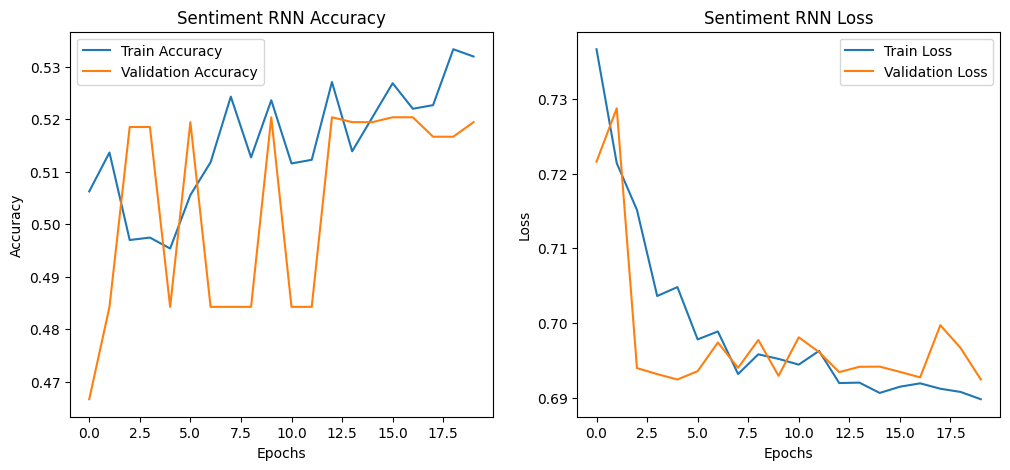

In [106]:
# 6. Evaluate and plot results
def plot_history(history, title):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Plot for Sentiment
plot_history(history_sentiment_rnn, 'Sentiment RNN')

## Model Evaluation

Fungsi ini digunakan untuk mengevaluasi kinerja model dengan classification report dan confusion matrix.

`classification_report()` memberikan metrik evaluasi seperti precision, recall, dan f1-score.

`ConfusionMatrixDisplay()` digunakan untuk memvisualisasikan confusion matrix, yang menunjukkan seberapa baik model mengklasifikasikan masing-masing kelas.


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Classification Report for Sentiment RNN:

              precision    recall  f1-score   support

    Negative       0.52      0.99      0.68       557
    Positive       0.64      0.02      0.03       523

    accuracy                           0.52      1080
   macro avg       0.58      0.50      0.36      1080
weighted avg       0.58      0.52      0.37      1080



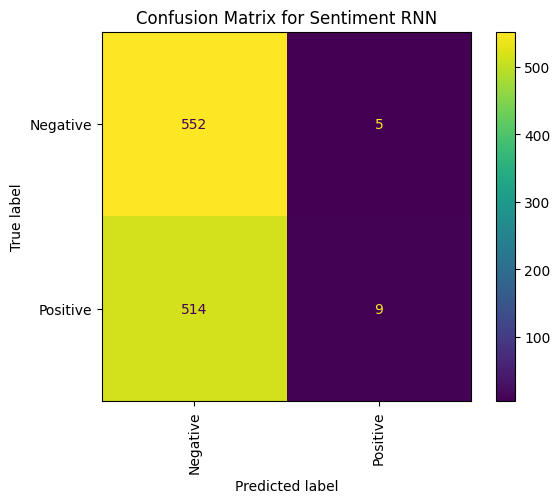

In [105]:
# Classification report and confusion matrix
def evaluate_model(model, X_test, y_test, label_encoder, title):
    y_pred = np.argmax(model.predict(X_test), axis=1)
    print(f"Classification Report for {title}:\n")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    disp.plot(cmap='viridis', xticks_rotation='vertical')
    plt.title(f"Confusion Matrix for {title}")
    plt.show()

# Evaluate Sentiment Model
evaluate_model(sentiment_rnn_model, X_test_sentiment_pad, y_test_sentiment_enc, label_encoder_sentiment, "Sentiment RNN")